# Subset processes

The WPS flyingpigeon provides several processes to perform spatial subsets of netCDF files: 

- **subset_bbox**: Crop netCDF files to a given latitude longitude bounding box. 
- **subset_countries**: Crop netCDF files to only the intersection of predefined countries.
- **subset_continents**: Crop netCDF files to only the intersection of predefined continents.
- **subset_wfs_polygon**: Crop netCDF files to only the intersection of given polygons available on a given WFS server. 

Note that subsetting operations do not average or reduce results over the selected area, they only return the grid sells intersecting with the area. A mask is applied to cells that are outside the selected area, but inside the rectangular grid required for netCDF files.  


In [1]:
# Import the WPS client and connect to the server
from birdy import WPSClient
import birdy 
from os import environ

# To display Images from an url
from IPython.core.display import HTML 
from IPython.display import Image

# Download files stored in a metalink
from metalink import download
import tempfile

# wait until WPS process is finished
import time

In [2]:
# This cell is for server admnistration test purpose
# Ignore this cell and modify the following cell according to your needs

fp_server = environ.get('FYINGPIGEON_WPS_URL')
print(fp_server)  # link to the flyingpigoen server

http://localhost:8093/wps


In [3]:
# URL to a flyingpigeon server
# fp_server = 'https://pavics.ouranos.ca/twitcher/ows/proxy/flyginpigeon/wps'

**Connect to the server with birdy client**

In [4]:
# Simple connection (not recommended for larger processing)
fp = WPSClient(fp_server)
# Asyncronous connection with progess status requests
fp_i = WPSClient(url=fp_server, progress=True)

**Explore the available processes:** 

In [5]:
# Enter `fp?` for general exploration on processes provided by flyingpigeon
# fp?

# Or get help for a process in particular
help(fp.subset_continents) # or type: fp.subset_countries?

Help on method subset_continents in module birdy.client.base:

subset_continents(resource=None, region='Africa', mosaic=False) method of birdy.client.base.WPSClient instance
    Return the data whose grid cells intersect the selected continents for each input dataset.
    
    Parameters
    ----------
    region : {'Africa', 'Asia', 'Australia', 'North America', 'Oceania', 'South America', 'Antarctica', 'Europe'}string
        Continent name.
    mosaic : boolean
        If True, selected regions will be merged into a single geometry.
    resource : ComplexData:mimetype:`application/x-netcdf`, :mimetype:`application/x-tar`, :mimetype:`application/zip`
        NetCDF Files or archive (tar/zip) containing netCDF files.
    
    Returns
    -------
    output : ComplexData:mimetype:`application/x-netcdf`
        NetCDF output for first resource file.
    metalink : ComplexData:mimetype:`application/metalink+xml; version=4.0`
        Metalink file with links to all NetCDF outputs.



In [6]:
# Specify input files
base_url = 'https://www.esrl.noaa.gov/psd/thredds/fileServer/Datasets/ncep.reanalysis.dailyavgs/surface/'
urls = [base_url + f'slp.{year}.nc' for year in range(2000, 2002)]

## Subset over a bounding box 

Note that all netCDF input files will be subsetted individually. 

In [7]:
# bbox subset of one file without interaction to the server

resp = fp.subset_bbox(
            resource=urls[0], # can be also a list of files but it is recommended to run large processes with fp_i
            lon0=20,
            lon1=70,
            lat0=10,
            lat1=50,
            start=None,     # optional to select a time periode
            end=None,
            variable=None,  # can be set if the variable is known, otherwise the process detects the variable name 
            )

# Check the output files:
bbox = resp.get()

In [8]:
# bbox of multiple files 

resp = fp_i.subset_bbox(
            resource=urls, 
            lon0=20,
            lon1=70,
            lat0=10,
            lat1=50,
            start=None,     # optional to select a time periode
            end=None,
            variable=None,  # can be set if the variable is known, otherwise the process detects the variable name 
            )

# using fp_i you need to wait until the processing is complete!

timeout = time.time() + 60*5   # 5 minutes from now

while resp.getStatus() != 'ProcessSucceeded': 
    time.sleep(1)
    if time.time() > timeout:  # to avoid endless waiting if the process failed
        break

# Get the output files:
bbox = resp.get()

In [9]:
# Plot the test file with the flyingpigeon plot function 
out_plot = fp.plot_map_timemean(resource=bbox.output)

# and display the output
Image(url= out_plot.get()[0], width=400)

In [10]:
# If you want to download the result files: 

path = tempfile.mkdtemp()
files = download.get(bbox.metalink, path=path, segmented=False, force=True)
len(files)

Metalink content-type detected.


2

## Subset over a continent

As for bounding box subsetting, all netCDF input files are subsetted individually. Here, it is possible to specifiy one or multiple continents. If `mosaic` is `True`, all continents are merged into one shape before subsetting. If `False`, each input file is subsetted over each polygon, such that the number of output files is the number of input files times the number of continents.  

The `subset_countries` process works the same with polygons for countries instead of continents. 

There are two outputs: 
* a netCDF file to have a quick test to check if the process went according to the users needs
* a metalink file with the list of all output files

In [11]:
# Run the process
resp = fp_i.subset_continents(resource=urls, region=['Europe', 'Africa'], mosaic=True)

# using fp_i you need to wait until the processing is complete!
timeout = time.time() + 60*5   # 5 minutes from now

while resp.getStatus() != 'ProcessSucceeded': 
    time.sleep(1)
    if time.time() > timeout:  # to avoid endless waiting if the process failed
        break

# Check the output files:
cont = resp.get()



In [12]:
# plot the test file (url of output) with the flyingpigon plot function 
resp = fp.plot_map_timemean(resource=cont.output)


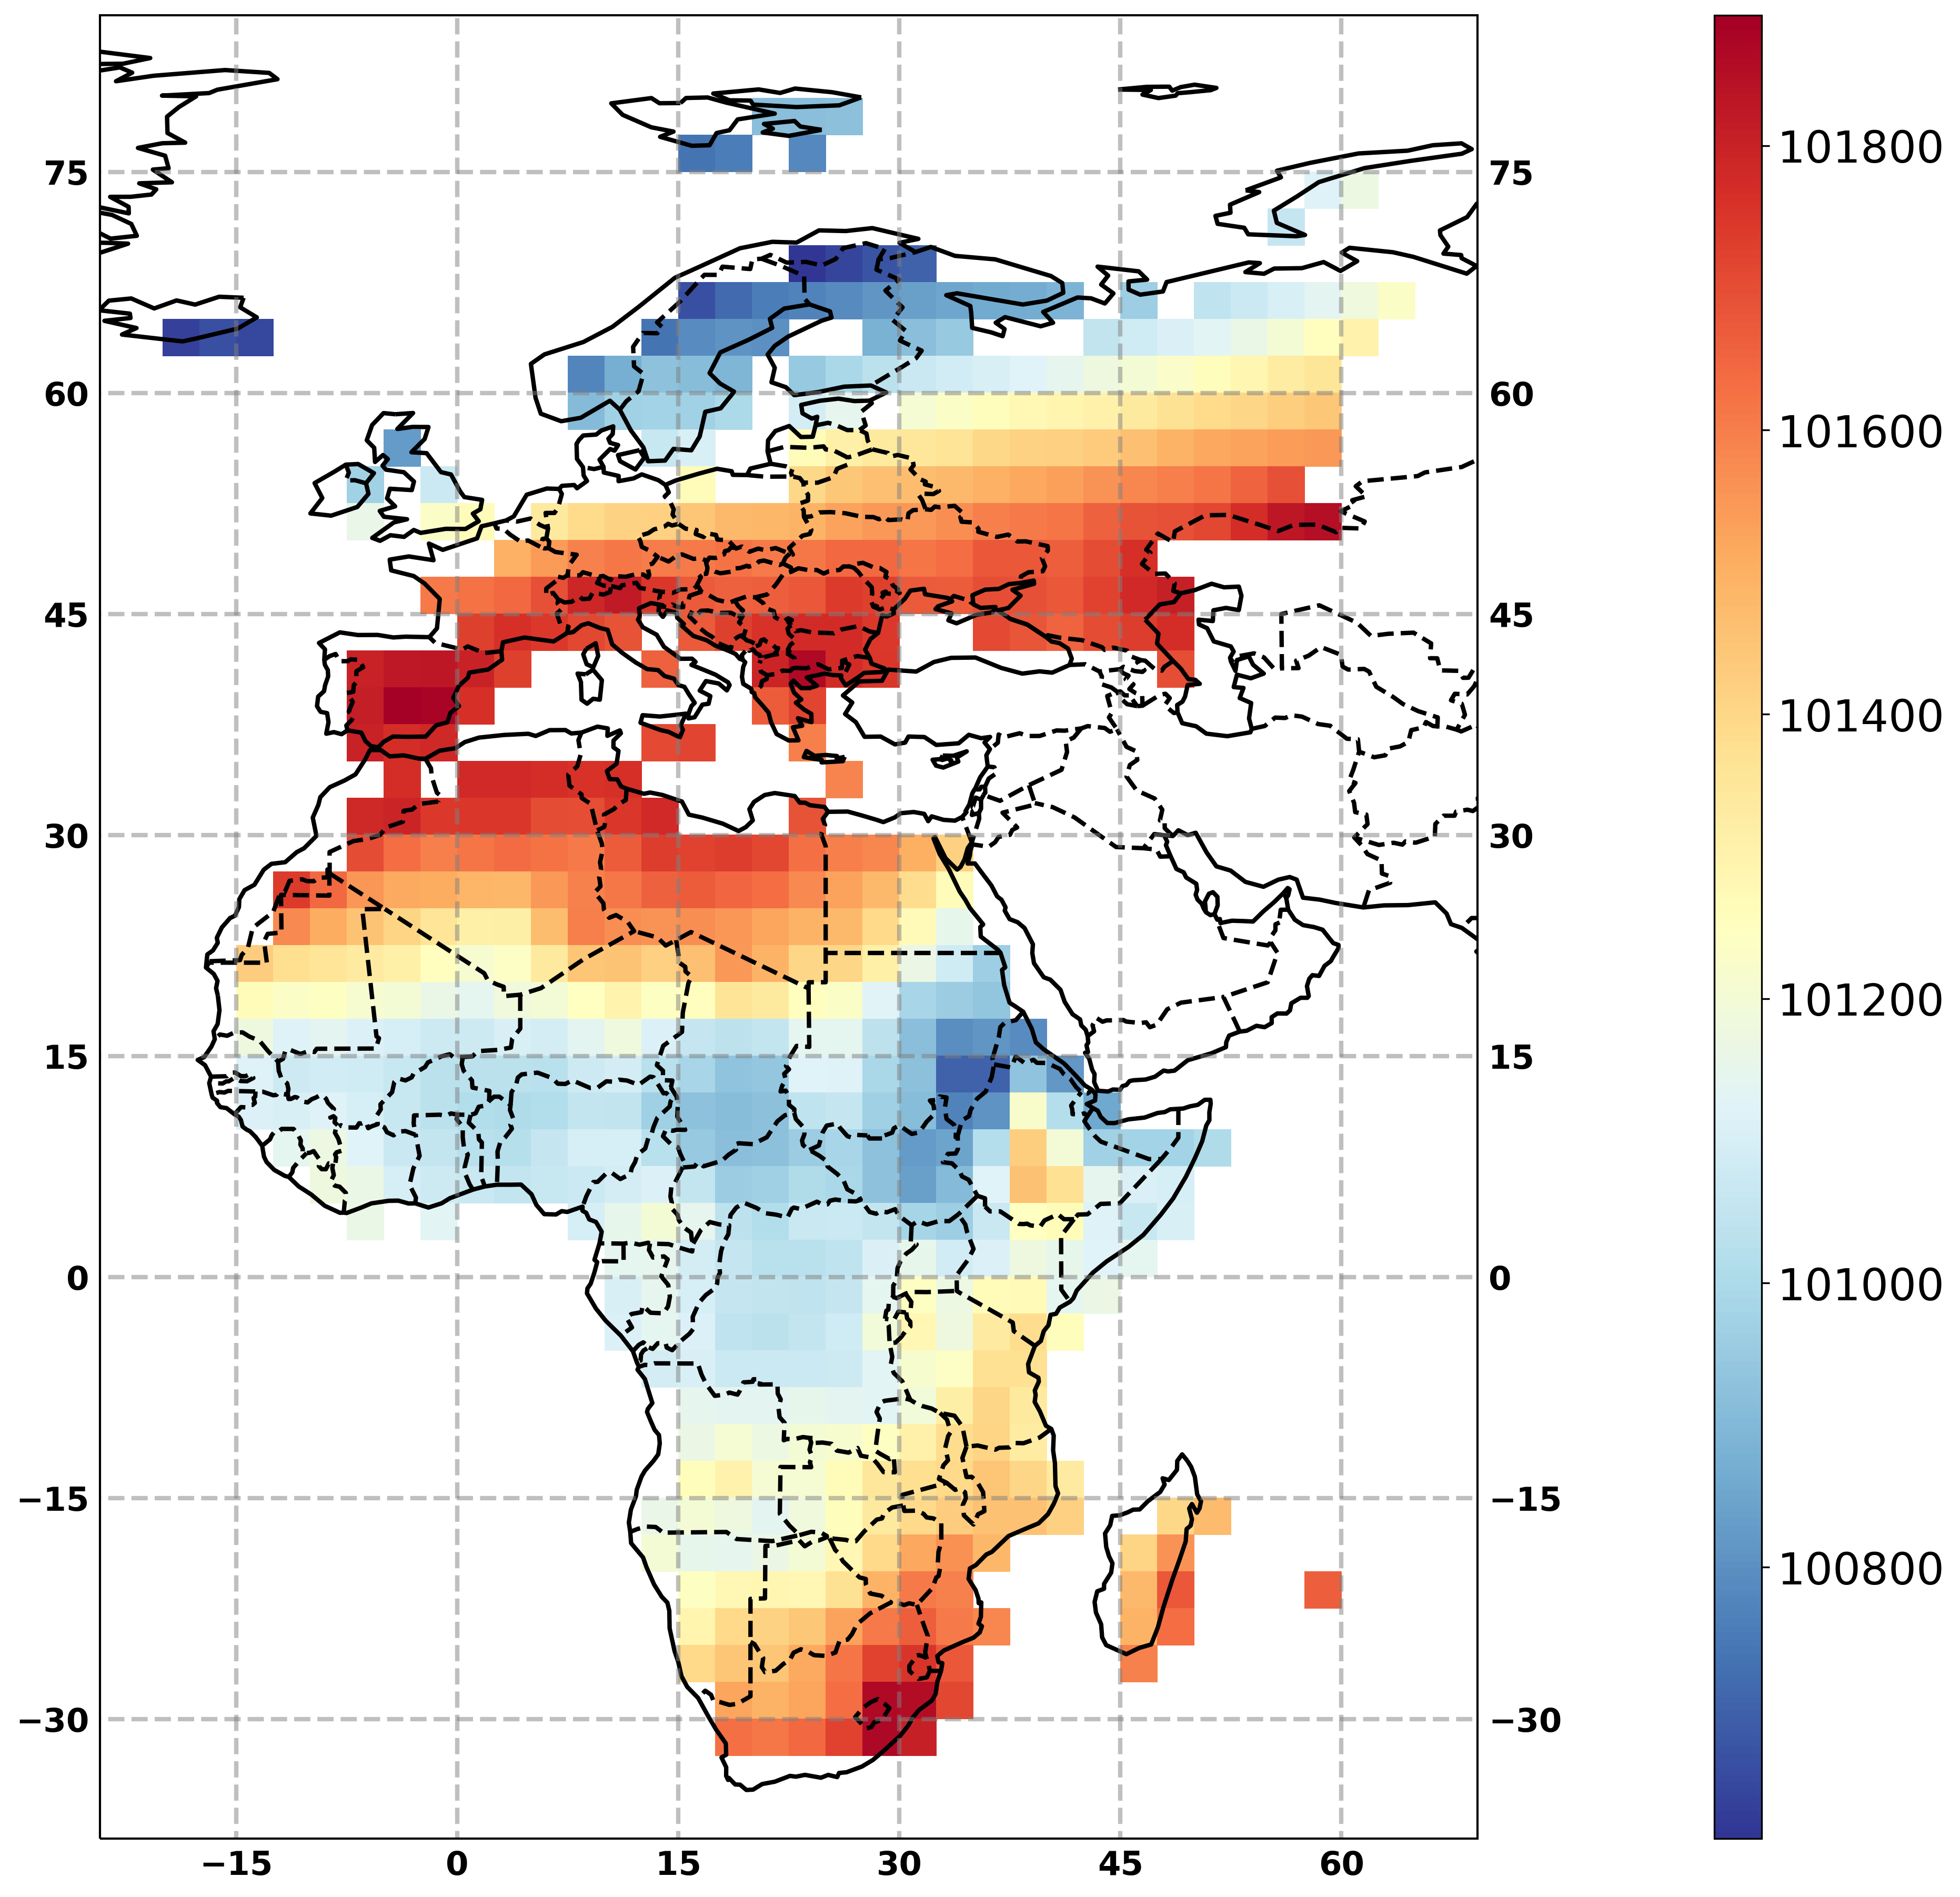

In [13]:
# The plot process returnes one graphic file. 
# It can be plotted directly by asking birdy to get python objects, instead of links to files.
resp.get(asobj=True).plotout_map

## Subset with WFS server 

In [14]:

inputs = dict(nc="https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/birdhouse/nrcan"
                     "/nrcan_northamerica_monthly"
                     "/tasmax/nrcan_northamerica_monthly_2015_tasmax.nc",
                  typename="public:USGS_HydroBASINS_lake_na_lev12",
                  geoserver="https://pavics.ouranos.ca/geoserver/wfs",
                  fid1="USGS_HydroBASINS_lake_na_lev12.67061",
                  fid2="USGS_HydroBASINS_lake_na_lev12.67088",
                  mosaic=False)

              
# resp =  fp_i.subset_wfs_polygon(resource=inputs['nc'],
#                                 typename=inputs['typename'],
#                                 featureids=inputs['fid1'],
#                                 geoserver=inputs['geoserver'],
#                                 mosaic=False,
#                                 start=None,
#                                 end=None,
#                                 variable=None,
#                                 )


In [15]:
# # using fp_i you need to wait until the processing is complete!
# timeout = time.time() + 60*5   # 5 minutes from now

# while resp.getStatus() != 'ProcessSucceeded': 
#     time.sleep(1)
#     if time.time() > timeout:  # to avoid endless waiting if the process failed
#         break

# outputs = resp.get()